<a href="https://colab.research.google.com/github/DnYAlv/computer_vision/blob/main/lec/corner_detection/harris_corner_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Harris Corner Detection

By: Denny Alvito Ginting

The following code is inspired from:
https://www.geekering.com/programming-languages/python/brunorsilva/harris-corner-detector-python/ 

## Importing Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import cv2
from google.colab.patches import cv2_imshow

## Loading Image

In [ ]:
def visualize_img(img, title):
  plt.figure(figsize=(12,6))
  plt.imshow(img, cmap='gray')
  plt.axis('off')
  plt.title(title)
  plt.show()

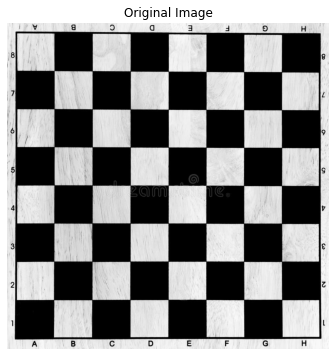

In [ ]:
img = cv2.imread('/content/image1.jpg')

# GrayScaling
grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

visualize_img(grayscale, 'Original Image')

## Computing Gaussian Derivatives at Each Pixel
To perform this method, we can apply two things:
- Start with applying the grayscaled image with `Gaussian Blur Filter`
- Utilize `Sobel Operator Kernel` to compute the derivatives.

In [ ]:
# Transform to float to enhance the detail of each pixel
grayscale = grayscale.astype(np.float64)

# Gaussian Filtering
img_gaussian = cv2.GaussianBlur(grayscale, (3,3), 0)

In [ ]:
def compute_gradient(img):

  """
  @Param : Image which has been filtered with Gaussian filter

  Approach:
  1. Define the convolution kernel mask (Sobel)
  2. Convolve the image with the mask
  3. Compute the derivative which then will be used on M matrix (next step)

  Returns:
  Dx2, Dy2, and Dxy

  """

  # Mask to take Gradient X
  Gx = np.array([[-1, 0, 1],
                 [-2, 0, 2],
                 [-1, 0, 1]], np.float32)

  # Mask to take Gradient Y
  Gy = np.array([[1, 2, 1],
                 [0, 0, 0],
                 [-1, -2, -1]], np.float32)
  
  # Perform convolution process
  # Convolve with X orientiation
  dx = ndimage.filters.convolve(img, Gx)

  # Convolve with Y orientiation
  dy = ndimage.filters.convolve(img, Gy)

  dx2 = np.square(dx)
  dy2 = np.square(dy)
  dxy = dx*dy

  return dx2, dy2, dxy

In [ ]:
dx2, dy2, dxy = compute_gradient(img_gaussian)

## Compute Second Moment Matrix M in a Gaussian Window Around each Pixel and Compute the Corner Response Function R

Approach:
- Define Window Size
- Define alpha value (which is a constant value that will then be used on `Corner Function`
- Create matrix R

In [ ]:
def corner_response(img, dx2, dxy, dy2, window_size=5, alpha=0.04):
  M, N = img.shape

  """
  Offset is window size divided by 2 since we want the window
  to traverse surrounding the image
  
  """
  offset = int(window_size/2)

  # R matrix to save the response function
  R_matrix = np.zeros((M,N))

  # Traverse through the image pixels to find the corners
  for y in range(offset, M - offset):
    for x in range(offset, N - offset):

      """
      Process through the traversal:
      1. Calculate the sum of Ix Squared, Ixy, and Iy Squared on
         created window
      2. Create the M matrix
      3. Calculate the determinant of M matrix, trace
         to compute the R function
      4. Accomodate the R function to R matrix

      """

      Ix2 = np.sum(
          dx2[
              y - offset : y + 1 + offset,
              x - offset : x + 1 + offset
          ]
      )
      Iy2 = np.sum(
          dy2[
              y - offset : y + 1 + offset,
              x - offset : x + 1 + offset
          ]
      )
      Ixy = np.sum(
          dxy[
              y - offset : y + 1 + offset,
              x - offset : x + 1 + offset
          ]
      )

      # Compute M
      M = np.array([
          [Ix2, Ixy],
          [Ixy, Iy2]
      ])

      # Compute Corner Response Function R
      det = np.linalg.det(M)
      trace = np.matrix.trace(M)
      R = det - alpha * (trace**2)
      R_matrix[y - offset, x - offset] = R
  
  return R_matrix

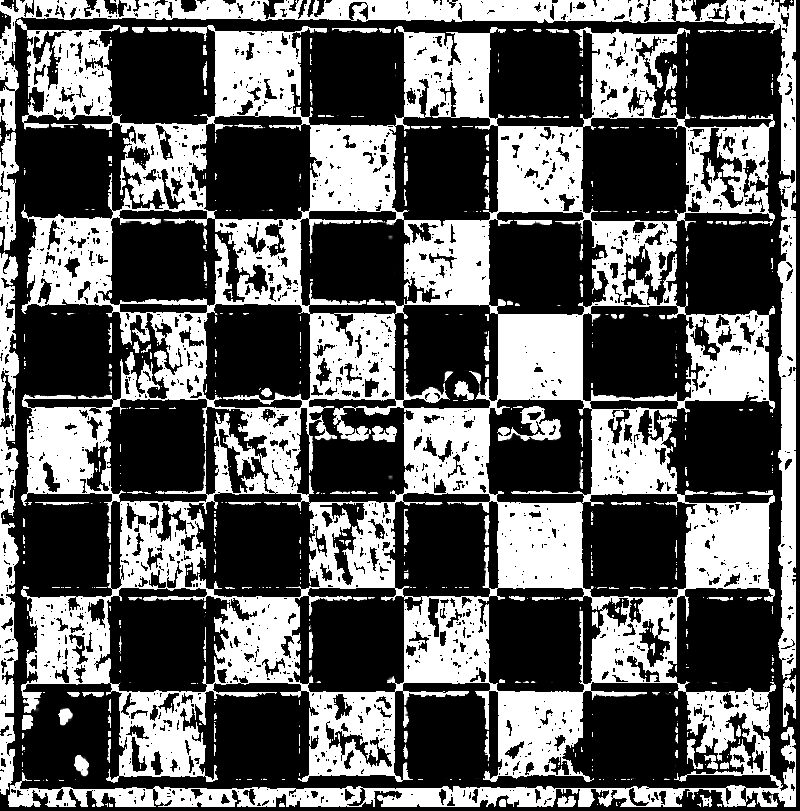

In [ ]:
R_matrix = corner_response(img_gaussian, dx2, dxy, dy2)
cv2_imshow(R_matrix)

## Compute The Threshold R
In this process we basically want to filters 3 things based on given R:
- If R > 0 then `Corner`
- If R = 0 then `Flat`
- If R < 0 then `Edge`

In [ ]:
def threshold_R(img, img_gaussian, R_matrix, window_size=5, threshold=0.3):

  """
  @Params:
  - img : Original Image
  - threshold : defined threshold to filters the computed
    R function results

  Return:
    image : Image with corner based on R threshold,
    R_threshold

  """

  M, N = img_gaussian.shape
  image = img.copy()
  offset = int(window_size/2)
  R_threshold = np.zeros((M, N))
  R_matrix_norm = np.zeros((M, N))
  # Normalize the matrix
  cv2.normalize(R_matrix, R_matrix_norm, 0, 1, cv2.NORM_MINMAX)

  for y in range(offset, M - offset):
    for x in range(offset, N - offset):
      R_temp = R_matrix_norm[y, x]

      if R_temp > threshold:
        R_threshold[y, x] = R_temp
        cv2.circle(image, (x, y), 3, (0, 0, 255))
  
  return image, R_threshold

In [ ]:
img_threshold_R, R_threshold = threshold_R(img, img_gaussian, R_matrix)

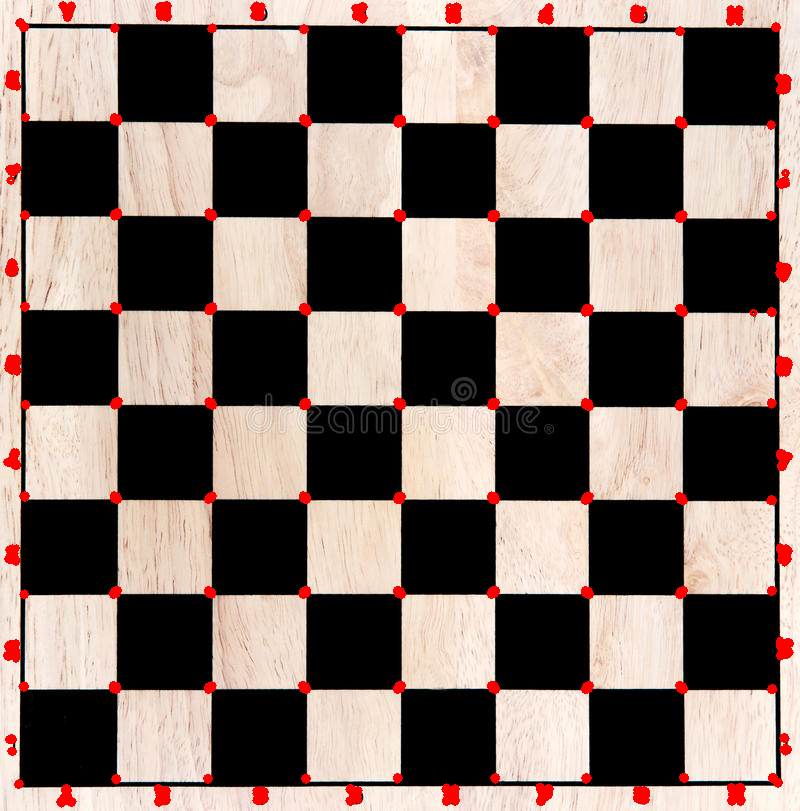

In [ ]:
cv2_imshow(img_threshold_R)

## Non Maximum Suppression

In [ ]:
def non_max_suppression(R_threshold, img_gaussian, img, window_size=5):
  M, N = img_gaussian.shape

  new_R_matrix = R_threshold.copy()

  shift_X = [-1, 0, 1, -1, 1, -1, 0, 1]
  shift_Y = [-1, -1, -1, 0, 0, 1, 1, 1]

  """
  Process:
  - Traverse through the matrix
  - Find the Local Max (Highest R value in the window)

  """

  for y in range(1, M-1):
    for x in range(1, N-1):
      local_maxima = 0

      for r_val in range(len(shift_X)):
        Sx = shift_X[r_val]
        Sy = shift_Y[r_val]

        """
        Logic:

        IF exists R matrix value that higher than
            local maxima, then take the local maxima
        ELSE set it to 0
        
        """

        if new_R_matrix[y + Sy, x + Sx] > local_maxima:
          local_maxima = new_R_matrix[y + Sy, x + Sx]
        else:
          new_R_matrix[y + Sy, x + Sx] = 0
  
  # Return Visualization Purpose
  threshold = 0.3

  image_non_max = img.copy()

  offset = int(window_size/2)

  for y in range(offset, M - offset):
    for x in range(offset, N - offset):
      R_non_max = new_R_matrix[y, x]

      if R_non_max > threshold:
        cv2.circle(image_non_max, (x, y), 3, (0,0,255))
  
  return image_non_max, new_R_matrix

In [ ]:
image_non_max, R_matrix_non_max = non_max_suppression(R_threshold,
                                                      img_gaussian,
                                                      img)

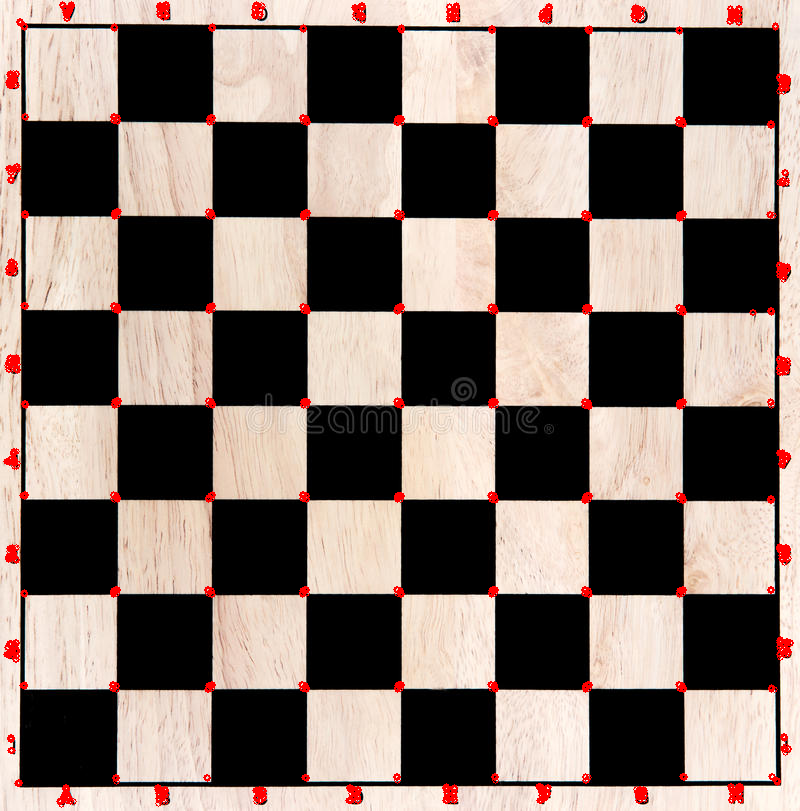

In [ ]:
cv2_imshow(image_non_max)

> As we can see, our `Harris Corner Detector` can detect the corner of this `Chess Board`, which means that our detector can detect well enough.